# 데이터 전처리 - 아스카로바

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 데이터 폴더 경로
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/3months_data'  # Update with the correct path


In [ ]:
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]


#가능한 모든 인코딩
def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")


valid_dataframes = []
#모든 파일을 포함한 dataframe 만들기
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:  # Check if the DataFrame has data
            print(f"File '{file}' read successfully with {len(df)} rows.")
            valid_dataframes.append(df)
        else:
            print(f"File '{file}' is empty and will be skipped.")
    except ValueError as e:
        print(e)
#empty 파일 제외한 모든 파일을 dataframe으로 추가하기

# Combine only the valid DataFrames
if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()  # Empty DataFrame if no valid files found

# Verify the combined DataFrame
print(f"Total rows in combined data: {len(combined_data)}")
print(combined_data.head())



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
combined_data = combined_data.drop(columns=[
    "생성일",
    "소비전류",
    "진동센서1",
    "진동센서2",
    "운전시간",
    "정상 운전 확률",
    "송풍기 고장 확률",
    "AIR 댐퍼 고장 확률",
    "GAS 앰퍼 고장 확률",
    "확률 업데이트 시간",
    "순간 스팀량",
    "입출력법 효율",
    "열 손실법 효율"

])

# Scale numerical features (optional, but good practice)
scaler = StandardScaler()
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

combined_data.fillna(method='ffill', inplace=True)  # Forward fill missing values
combined_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining NaNs

# Select numerical columns only
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in numerical columns with the mean value
combined_data[numerical_columns] = combined_data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# For categorical columns, fill missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[df.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(df.select_dtypes(include=['object']))

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])




In [ ]:
combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')


In [ ]:
combined_data.head()

In [ ]:
#checking if data preprocessing was correct
print(combined_data.isna().sum())  # Shows the count of NaNs in each column
print(combined_data.isna().sum().sum())  # Total count of missing values
print(combined_data.info())


# XGBoost (RF 알고리즘으로 하이퍼 파라미터 튜닝) - 주열

## 모델

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = df.drop(columns=['효율(순간)'])  # 타겟 변수를 제외한 특징 변수
y = df['효율(순간)']  # 타겟 변수

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.4 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# 랜덤 서치 설정
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=1000,  # 시도할 조합의 수
    scoring='neg_mean_squared_error',
    cv=5,  # 5겹 교차검증
    verbose=1,
    random_state=42,
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


ValueError: 
All the 5000 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1459, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 603, in _transform_pandas_df
    pandas_check_dtypes(data, enable_categorical)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 569, in pandas_check_dtypes
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 356, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:배기가스온도3: object, 에코 온도2: object


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np  # numpy를 임포트하여 sqrt 사용

# 예측
y_pred = random_search.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산

# MAPE 계산
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE 계산 (백분율로)

# 결과 출력
print(f'테스트 데이터 MSE: {mse}')
print(f'테스트 데이터 MAE: {mae}')
print(f'테스트 데이터 RMSE: {rmse}')
print(f'테스트 데이터 MAPE: {mape:.2f}%')  # MAPE를 소수점 2자리로 포맷


테스트 데이터 MSE: 0.040415572600721386
테스트 데이터 MAE: 0.04854537751706938
테스트 데이터 RMSE: 0.20103624698228273
테스트 데이터 MAPE: 202.13%


## 데이터 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

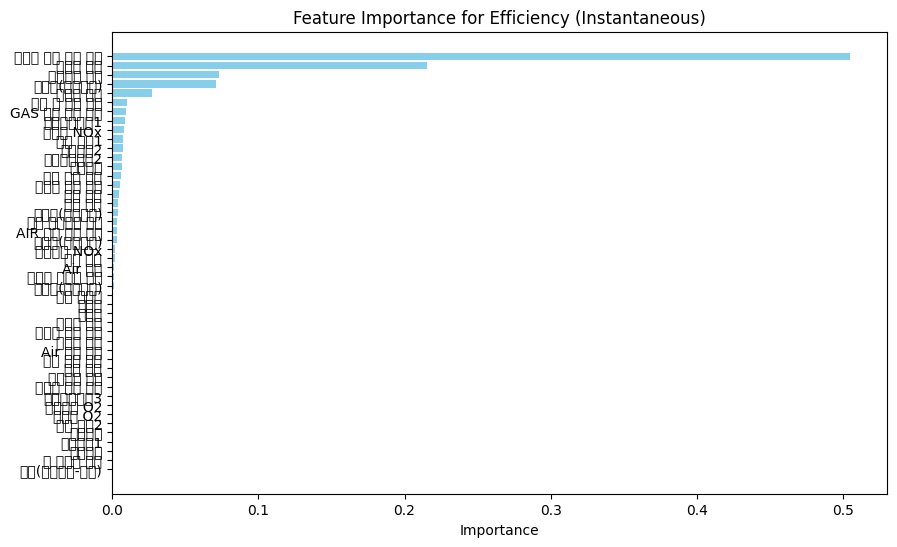

         Feature  Importance
15  재순환 외기 댐퍼 입력    0.504835
5         송풍기 입력    0.215663
43       입출력법 효율    0.073043
29     급수량(적산유량)    0.071047
17        보일러 온도    0.027077
21    배기 재 순환 온도    0.009885
40  GAS 앰퍼 고장 확률    0.009683
18       배기가스온도1    0.008781
28       재순환 NOx    0.008013
22        에코 온도1    0.007575
35         진동센서2    0.007518
19       배기가스온도2    0.006495
36          운전시간    0.006492
37      정상 운전 확률    0.006362
38     송풍기 고장 확률    0.005225
16         급수 수위    0.004926
2          설정 압력    0.004081
30     급수량(순간유량)    0.003910
41    확률 업데이트 시간    0.003570
39  AIR 댐퍼 고장 확률    0.003474
31     연료량(적산유량)    0.003401
25      배기가스 NOx    0.002048
8          가스 댐퍼    0.001761
10        Air 댐퍼    0.001604
4     송풍기 인버터 출력    0.001545
32     연료량(순간유량)    0.001067
42        순간 스팀량    0.000920
0            생성일    0.000000
1            부하율    0.000000
3         보일러 압력    0.000000
13     재순환 외기 댐퍼    0.000000
12        재순환 댐퍼    0.000000
11     Air 댐퍼 입력    0.000000
9       가스 댐퍼 

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# XGBoost 모델에서 특성 중요도 가져오기
feature_importances = random_search.best_estimator_.feature_importances_

# 특성 이름과 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순서부터 표시
plt.xlabel('Importance')
plt.title('Feature Importance for Efficiency (Instantaneous)')
plt.show()

# 특성 중요도 출력
print(importance_df)


XGBoost (RF 알고리즘으로 하이퍼 파라미터 튜닝) -희성

In [ ]:
import pandas as pd  # 데이터 처리에 사용되는 pandas 라이브러리 임포트
import numpy as np  # 수치 계산을 위한 numpy 라이브러리 임포트
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # 데이터 분리 및 하이퍼파라미터 튜닝을 위한 모듈 임포트
import xgboost as xgb  # XGBoost 모델을 사용하기 위한 라이브러리 임포트
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 회귀 모델 평가를 위한 메트릭 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 matplotlib 임포트
import seaborn as sns  # 데이터 시각화를 위한 seaborn 임포트

# 데이터 불러오기
combined_data = pd.read_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv')  # 전처리된 CSV 파일을 읽어와 DataFrame으로 저장

# 특성과 타겟 변수 분리
X = combined_data.drop(columns=['효율(순간)'])  # 타겟 변수를 제외한 특징 변수로 X 설정
y = combined_data['효율(순간)']  # 타겟 변수로 '효율(순간)' 열 설정

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 데이터를 80% 훈련 세트, 20% 테스트 세트로 분리

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')  # 회귀 모델을 위한 XGBoost 초기화

# 하이퍼파라미터 범위 설정
param_dist = {  # 하이퍼파라미터 범위 정의
    'n_estimators': np.arange(50, 500, 50),  # 트리의 개수
    'max_depth': np.arange(3, 10),  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'subsample': np.arange(0.5, 1.0, 0.1),  # 각 트리가 학습할 데이터 비율
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)  # 각 트리가 사용할 피처 비율
}

# 랜덤 서치 설정
random_search = RandomizedSearchCV(  # 랜덤 서치 객체 생성
    xgb_model,  # 사용할 모델
    param_distributions=param_dist,  # 하이퍼파라미터 범위
    n_iter=100,  # 시도할 조합의 수
    scoring='neg_mean_squared_error',  # 평가 지표로 음의 평균 제곱 오차 사용
    cv=5,  # 5겹 교차 검증
    verbose=1,  # 진행 상황 출력
    random_state=42,  # 난수 시드 설정
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)  # 훈련 데이터를 사용하여 랜덤 서치 실행

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)  # 찾은 최적의 하이퍼파라미터 출력

# 예측
y_pred = random_search.predict(X_test)  # 테스트 데이터를 사용하여 예측 수행

# 성능 평가
mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차 계산
mae = mean_absolute_error(y_test, y_pred)  # 평균 절대 오차 계산
rmse = np.sqrt(mse)  # 제곱근 평균 제곱 오차 계산

# MAPE 계산
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 평균 절대 비율 오차 계산 (백분율로)

# 결과 출력
print(f'테스트 데이터 MSE: {mse}')  # 테스트 데이터의 MSE 출력
print(f'테스트 데이터 MAE: {mae}')  # 테스트 데이터의 MAE 출력
print(f'테스트 데이터 RMSE: {rmse}')  # 테스트 데이터의 RMSE 출력
print(f'테스트 데이터 MAPE: {mape:.2f}%')  # 테스트 데이터의 MAPE 출력 (소수점 2자리로 포맷)

# 상관 행렬 시각화
plt.figure(figsize=(12, 8))  # 그림 크기 설정
correlation_matrix = combined_data.corr()  # 상관 행렬 계산
sns.heatmap(correlation_matrix[['효율(순간)']].sort_values(by='효율(순간)', ascending=False),  # '효율(순간)'과의 상관 관계 시각화
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # 각 셀에 값 표시, 색상 맵 설정
plt.title('Correlation with Efficiency (Instantaneous)')  # 제목 설정
plt.show()  # 그래프 출력


Fitting 5 folds for each of 100 candidates, totalling 500 fits


ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1459, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 603, in _transform_pandas_df
    pandas_check_dtypes(data, enable_categorical)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 569, in pandas_check_dtypes
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 356, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:배기가스온도3: object, 에코 온도2: object
